<a href="https://colab.research.google.com/github/Pilo1961/QuestionAnswer_System/blob/master/code/Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Preguntas y Respuestas
## 03. Processing Data and Feature engineering


En el presente notebook se realiza el preprocesamiento de los datos que van a ser empleados en la implementación de los modelos supervisado. En el intermedio, implementamos dos modelos no supervisados, obteniendo accuracies de 59.9 y 36.9 por ciento.

### 3.1 Setup

In [1]:
# Imports

import pickle
from textblob import TextBlob
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3.2. Read data

In [0]:
#load train data from pickle
with open("/content/drive/My Drive/QA/df_train.pkl", "rb") as f:
    train_data = pickle.load(f)

train_data.drop(columns=['id','title'],inplace=True)
train_data.dropna(inplace=True)

In [0]:
print(train_data.shape)
train_data.head()

(87636, 4)


,answer_start,text,context,question
0,515,Saint Bernadette Soubirous,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...
1,187,a copper statue of Christ,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?
2,279,the Main Building,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...
3,381,a Marian place of prayer and reflection,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?
4,92,a golden statue of the Virgin Mary,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...


In [0]:
# Load embeddings from pickle
# Train question embedding
with open("/content/drive/My Drive/QA/train_question.pkl", "rb") as f:
    train_question_emb = pickle.load(f)

# Train context embeddings
with open("/content/drive/My Drive/QA/train_dict.pkl", "rb") as f:
    train_dict = pickle.load(f)

### 3.3 Format data

Ordenamos los datos en forma de listas anidadas.
* La variable context_embedding es una lista anidada con los embeddings de las oraciones del contexto.
* La variable contexts contiene las oraciones tokenizadas del contexto
* q_embedding tiene los embeddings de las preguntas.

In [0]:
# Genera una lista de listas para los contextos
# \y para los embeddings de los contextos

contexts=[]
context_embedding=[]
last_context=[]

for context in train_data['context']:

  if context == last_context:# Si es el mismo contexto usa lo que ya calculamos
    contexts.append(temp)
    context_embedding.append(temp_emb)
    continue
  
  temp=[]
  temp_emb=[]
  for sent in sent_tokenize(context):
    s=sent.lower()
    temp.append(s)
    e=train_dict[s]
    temp_emb.append(e)
  
  contexts.append(temp)
  context_embedding.append(temp_emb)
  last_context=context


In [0]:
# Todas las variables tienen la misma longitud que el df original
print(len(context_embedding))
print(len(contexts))
print(len(train_question_emb))

87636
87636
87636


In [0]:
df_context_embedding=pd.DataFrame(context_embedding)
df_contexts=pd.DataFrame(contexts)
df_question_embedding=pd.DataFrame(train_question_emb)

### 3.4 Generación variable target

Para hacer la variable target buscamos la respuesta literal dentro del contexto. El target es la oración donde aparece la respuesta.

In [0]:
train_data.head()

,answer_start,text,context,question
0,515,Saint Bernadette Soubirous,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...
1,187,a copper statue of Christ,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?
2,279,the Main Building,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...
3,381,a Marian place of prayer and reflection,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?
4,92,a golden statue of the Virgin Mary,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...


In [8]:
# Busca la oracion que tiene la respuesta literal dentro del contexto
# guarda la posicion de la oracion dentro del contexto
# Si no la encuentra deja target = -1
train_data["target"]=-1
for i in range (len(train_data)):
  respuesta=train_data["text"][i].lower()
  for j, sent in enumerate(contexts[i]):
    if respuesta in sent: 
      train_data["target"][i] = j
      break


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
#casos que no se encontro la respuesta
sum(train_data["target"]==-1)

981

Encontramos 981 casos que representan el 1.11 por ciento. 
Dado que se trata de un problema de comprehensión de lectura y un supuesto en el planteamiento es que encontramos la respuesta a la pregunta literal en el contexto, procedemos a quitar esos casos de nuestro análisis.

In [0]:
# Quitamos las filas que no tienen target en el df
index = np.where(train_data["target"]==-1)
contexts = np.delete(contexts,index,axis=0)
context_embedding = np.delete(context_embedding,index,axis=0)
train_question_emb = np.delete(train_question_emb,index,axis=0)

# Quitamos las filas que no tienen target en el df
index=train_data["target"]==-1
train_data=train_data[-index].reset_index()

In [10]:
# La nueva longitud de los datos
print(train_data.shape)
print(len(context_embedding))
print(len(contexts))
print(len(train_question_emb))

(86655, 6)
86655
86655
86655


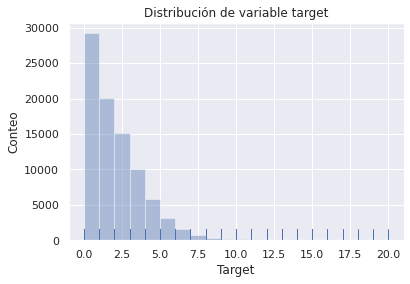

In [11]:
sns.set(style="darkgrid")
g = sns.distplot(train_data["target"], kde=False, rug =True, color="b", bins=20)
g.set_title("Distribución de variable target")
g.set_ylabel('Conteo')
g.set_xlabel('Target')
plt.show()

In [0]:
print(np.quantile(train_data["target"],.99))
pd.DataFrame(train_data["target"]).describe()

7.0


,target
count,86655.000000
mean,1.645398
std,1.802559
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,20.000000


###3.5 Distancias Coseno y Euclidiana


En el presente apartado, calculamos la distancia coseno y la euclidiana entre las oraciones del contexto y la pregunta, dicha información, junto con la calculada en los apartados previos y posteriores, constituirán los insumos de los modelos supervisados que desarollamos en el notebook [04. modelling](https://github.com/Pilo1961/QuestionAnswer_System/blob/master/code/02.%20modelling.ipynb).

En el intermedio, aprovechamos para implementar un modelo no supervisado.

In [0]:
# Definimos las distancias a utilizar
norma=lambda x:np.sqrt(sum(x*x))
distancia_coseno=lambda x,y: 1-(sum(x*y)/(norma(x)*norma(y)))
distancia_euclidiana=lambda x,y: norma(x-y)

In [0]:
# Calcula la distancia coseno y la euclidiana entre las oraciones del contexto y la pregunta
# Devuevle un array target con el indice de la oracion con la minima distancia
euclid_distance_target=[]
cosine_distance_target=[]
euclid_distance=[]
cosine_distance=[]

for i in range(len(train_data)):
  dc_min=1000
  de_min=1000
  temp_c=[]
  temp_e=[]
  for j, sent_emb in enumerate(context_embedding[i]):
    dist_euc=distancia_euclidiana(sent_emb,train_question_emb[i])
    dist_cos=distancia_coseno(sent_emb,train_question_emb[i])  
    temp_c.append(dist_cos)
    temp_e.append(dist_euc)

  euclid_distance_target.append(np.argmin(temp_e))
  cosine_distance_target.append(np.argmin(temp_c))
  euclid_distance.append(temp_e)
  cosine_distance.append(temp_c)
  if i%5000==0: print(i)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


#### 3.5.1 Implementación intermedia de un *modelo* no supervisado

In [0]:
train_data["euclid_prediction"]=euclid_distance_target
train_data["cosine_prediction"]=cosine_distance_target

In [0]:
import pickle

with open("/content/drive/My Drive/QA/dist_cosine.pkl", 'wb') as handle:
    pickle.dump(cosine_distance, handle)

with open("/content/drive/My Drive/QA/dist_euclid.pkl", 'wb') as handle:
    pickle.dump(euclid_distance, handle)

Revisamos el accuracy  del modelo no supervisado.

In [0]:
#Checa si la oracion que minimiza la distancia es la misma que la oracion target
euclid=0
cosine=0
for i in range(len(train_data)):
  right=train_data["target"][i]
  e=train_data["euclid_prediction"][i]
  c=train_data["cosine_prediction"][i]
  if(right==e):euclid+=1
  if(right==c):cosine+=1  

print("Cosine accuracy",cosine/len(train_data))
print("Euclidian accuracy",euclid/len(train_data))

Cosine accuracy 0.5996191795049334
Euclidian accuracy 0.3696613005596907


Usando la distancia cosento detectamos el 59.9% de las oraciones en el conjunto train.  
Usando la distancia euclidiana detectamos el 36.9% de las oraciones en el contexto que tienen la respuesta.

In [0]:
#Celda para verificar consistencia

i=5906
print("Distancia Euclidiana")
print(euclid_distance[i])
print("Target: ", euclid_distance_target[i])
print("Index del minimo:",np.argmin(euclid_distance[i]))
print("\n")
print("Distancia Coseno")
print(cosine_distance[i])
print("Target: ",cosine_distance_target[i])
print("Index del minimo:",np.argmin(cosine_distance[i]))

Distancia Euclidiana
[5.2625631927403305, 4.21635732745609, 3.5960816786122, 4.308840077891539, 4.374068086779395]
Target:  2
Index del minimo: 2


Distancia Coseno
[0.4612922809524779, 0.5593019660042353, 0.4051351904905818, 0.3781817001638521, 0.43483427939486885]
Target:  3
Index del minimo: 3


En la celda anterior vemos la distancia entre las oraciones del contexto y la pregunta.
El objetivo es verificar consistencia entre el minimo y el minimo que se tiene como target registrado.

### 3.6 Drop observations not meeting criterias

Nos limitamos a 10 oraciones por contexto. Cualquier texto con mas de 10 oraciones se limitará a 10.

In [0]:
df_context_embedding=pd.DataFrame(context_embedding,columns=["context_embedding"])

In [0]:
print(train_data.shape)
train_data.head()

(86655, 8)


,index,answer_start,text,context,question,target,euclid_prediction,cosine_prediction
0,0,515,Saint Bernadette Soubirous,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5,0,5
1,1,187,a copper statue of Christ,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,2,3,2
2,2,279,the Main Building,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,1,3,3
3,3,381,a Marian place of prayer and reflection,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,4,3,3
4,4,92,a golden statue of the Virgin Mary,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,1,3,1



### 3.7 Root analysis

En las siguientes celdas se busca la raíz de las oraciones para los contextos y para las preguntas. 

[Ejemplo de arboles](https://stackoverflow.com/questions/36610179/how-to-get-the-dependency-tree-with-spacy/39104235)

In [0]:
#Ejemplo de la estructura de una oración

import spacy
from nltk import Tree
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

en_nlp = spacy.load('en')
doc = en_nlp(contexts[0][3])
print(contexts[0][3])
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_


[to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]

next to the main building is the basilica of the sacred heart.
                  is                           
  ________________|__________                   
 |        next            basilica             
 |         |            _____|_______           
 |         to          |             of        
 |         |           |             |          
 |      building       |           heart       
 |    _____|______     |      _______|_____     
 .  the          main the   the          sacred



[None]

In [0]:
# calcula las raices de las oraciones de los contextos
# calcula las raices de las pregutnas
# Genera un vector que contiene el numero de raices en cada indice

questions_root=[]
context_root=[]
num_roots=[]


for i in range(len(train_data)):
  if train_data["context"][i]!=last_context: 
    roots=[st.stem(str(sent.root)) for sent in en_nlp(train_data["context"][i]).sents]
  context_root.append(roots)
  num_roots.append(len(roots))
  questions_root.append([st.stem(str(sent.root)) for sent in en_nlp(train_data["question"][i]).sents])
  last_context=train_data["context"][i]
  if i%5000==0: print(i)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


In [0]:
import pickle

with open("/content/drive/My Drive/QA/question_root.pkl", 'wb') as handle:
    pickle.dump(questions_root, handle)

with open("/content/drive/My Drive/QA/context_root.pkl", 'wb') as handle:
    pickle.dump(context_root, handle)

In [0]:
#hacemos un array con las posiciones en que coinciden la raiz de la pregunta y de las oraciones

root_index=[]

for i in range(len(questions_root)):
  c=[]
  a=np.array(context_root[i])
  b=np.array(questions_root[i])
  for root in b:
    temp=np.where(a==root)
    c=np.append(c,temp[0])
  root_index.append(c.astype('i'))
  if i%10000 ==0: print(i)


0
10000
20000
30000
40000
50000
60000
70000
80000


In [0]:
#Hace un one hot encoder de los root. Limita los resultados a las dimensiones indicadas.
dim=9
root_ohe=[]
for i in range(len(root_index)):
  a=np.zeros(60)
  a[root_index[i]]=1
  root_ohe.append(a[:dim])

root_ohe=pd.DataFrame(root_ohe)

In [0]:
root_ohe.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
import pickle

with open("/content/drive/My Drive/QA/root_ohe.pkl", 'wb') as handle:
    pickle.dump(root_ohe, handle)